# Segmenting a large dataset using a pretrained 3D Unet

In this notebook a workflow to segment large imaging volumes is implemented.
- The dataset is tiled with small chunks that correspond to the output size of the Unet.
- For each output chunk the corresponding input region to the network is calculated. Input regions that protrude beyond the image volume are completed by mirroring at the volume border
- The unet is applied to the input chunks which are then reassembled to give a complete segmentation mask of the original image. If available, several instances work in parallel to speed up the segmentation process.


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

from importlib import reload
import utilities, model

import os, sys, time
sys.path.append('../tools/')
import mosaic, metrics

import h5py
from tqdm import tqdm

In [2]:
# Fix for tensorflow-gpu issues that I found online... (don't ask me what it does)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [15]:
# Specify the path to the image volume stored as h5 file
image_path = "C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\large_image_0724.h5"
image_h5 = h5py.File(image_path, mode='r+') # Open h5 file with read / write access
print(image_h5.keys()) # Show Groups (Folders) in root Group of the h5 archive

<KeysViewHDF5 ['__DATA_TYPES__', 't0']>


In [16]:
group = image_h5['t0']
image = image_h5['t0/channel0'] # The image dataset is found in 't0/channel0'
print('found dataset with shape {}'.format(image.shape))
if 'unet' in group.keys():
    mask = group['unet']
    print('there allready is a channel named unet with shape {}'.format(mask.shape))
else:
    mask = group.create_dataset('unet', shape=image.shape, dtype=np.uint8) #allocate 8 bit integer tensor
    print('Allocated a segmentation mask of size {}'.format(mask.shape))


found dataset with shape (500, 2000, 2000)
Allocated a segmentation mask of size (500, 2000, 2000)


In [13]:
# delete the preexisting mask if necessary
#del image_h5['t0/unet']
#image_h5.close() # closing the image triggers memory release from h5 file

In [6]:
model_path = 'C:\\Users\\Linus Meienberg\\Google Drive\\Janelia\\ImageSegmentation\\3D Unet\\retrain0727\\3d_unet_0728.h5'
# Restore the trained model. Specify where keras can find custom objects that were used to build the unet
unet = tf.keras.models.load_model(model_path, compile=False,
                                  custom_objects={"InputBlock" : model.InputBlock,
                                                    "DownsampleBlock" : model.DownsampleBlock,
                                                    "BottleneckBlock" : model.BottleneckBlock,
                                                    "UpsampleBlock" : model.UpsampleBlock,
                                                    "OutputBlock" : model.OutputBlock})

In [7]:
# Implement the models preprocessing function
def preprocessImage(data):
    # clip the values at 1400 so that everything above is saturated, convert to float to prevent issues with unsigned int format
    data = np.clip(data, 0, 1400).astype(np.float32)
    # shift by the empirical mean and divide by the empirical std dev to get data with a approx 0 centered distribution and unit variance
    # this improves weight stability in the lower layers and allows for faster training
    # empirical values for mean and variance were obtained using image J on large_image_0724.h5
    data = np.divide( np.subtract(data, 140), 40 )
    return data

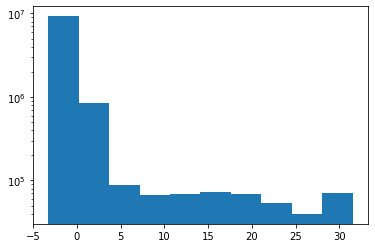

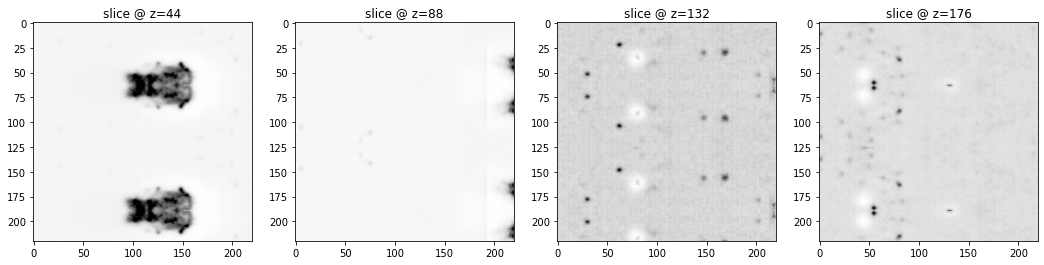

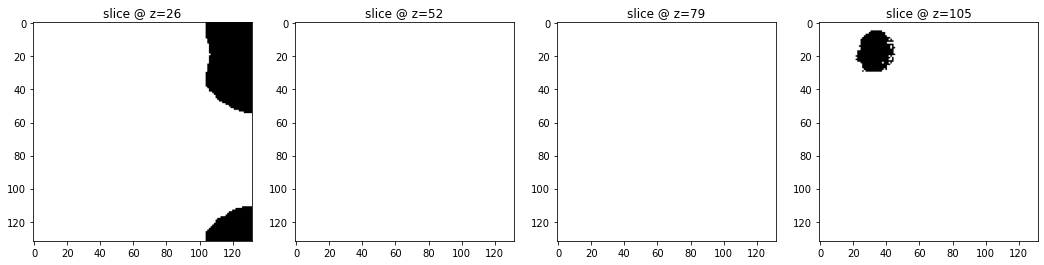

In [29]:
test_slice = preprocessImage(tiler._getSlice(500))
plt.hist(test_slice.flat, log=True)
test_pred = unet.predict(test_slice[np.newaxis,...,np.newaxis])
test_pred_mask = utilities.segmentationMask(test_pred)
utilities.showZSlices(test_slice, mode='h5')
utilities.showZSlices(test_pred_mask[0,...,0],mode='h5', vmin=0, vmax=1)

In [8]:
print('The unet works with\ninput shape {}\noutput shape {}'.format(unet.input.shape,unet.output.shape))

The unet works with
input shape (None, 220, 220, 220, 1)
output shape (None, 132, 132, 132, 2)


In [20]:
reload(mosaic)
tiler = mosaic.UnetTiler3D(image, mask=mask, output_shape=(132,132,132), input_shape=(220,220,220) )

In [11]:
# Check if tiler actually writes to the mask
#tiler._writeSlice(0,np.ones((132,132,132)))

In [30]:
start = time.time()
for i in tqdm(range(len(tiler)), desc='tiles processed'): # gives feedback on progress of for loop
    # Read input slice from volume
    input_slice = preprocessImage(tiler._getSlice(i))
    # Add batch and channel dimension and feed to unet
    output_slice = unet.predict(input_slice[np.newaxis,:,:,:,np.newaxis])
    output_mask = np.argmax(output_slice, axis=-1)[0,...] # use argmax on channels and remove batch dimension
    #print('unet output mask shape : '.format(input_slice.shape))
    tiler._writeSlice(i, output_mask)


end = time.time()
print('\ntook {:.1f} s for {} iterations'.format(end-start,len(tiler)))

tiles processed: 100%|██████████| 1024/1024 [08:58<00:00,  1.90it/s]
took 538.6 s for 1024 iterations



In [15]:
print(group.keys())
image_h5.close()

<KeysViewHDF5 ['channel0', 'unet']>


In [31]:
# load the mask 
ground_truth_path = "C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\large_mask_0724.h5"
ground_truth = h5py.File(ground_truth_path, mode='r')
true_mask = ground_truth['t0/channel0']
print(true_mask.shape)

(500, 2000, 2000)


In [32]:
true_mask = np.clip(true_mask, 0, 1)

In [33]:
metrics.intersection_over_union(mask[...],true_mask[...])

[0.9989929484069661, 0.8074010410489809]

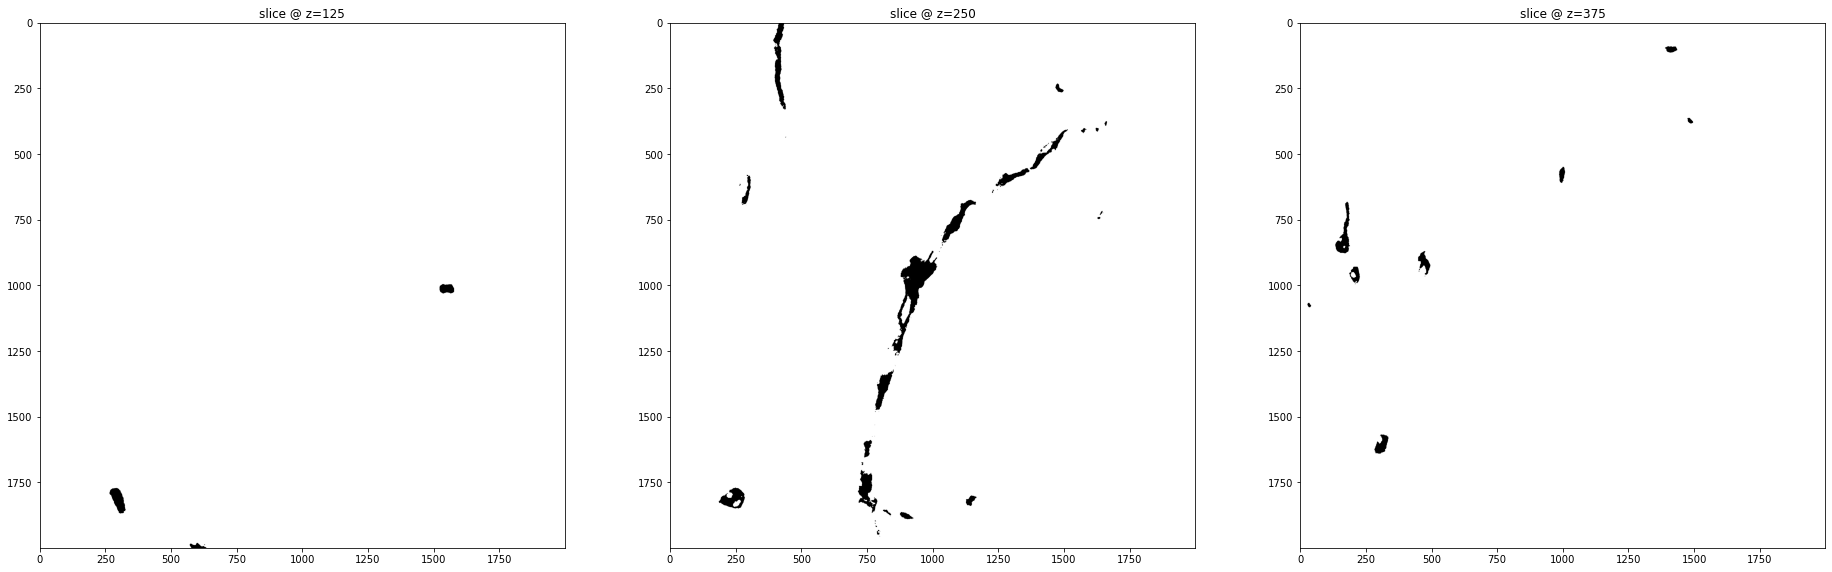

In [34]:
reload(utilities)
utilities.showZSlices(true_mask, mode='h5', n_slices=3, plot_size=10, vmin=0, vmax=1)

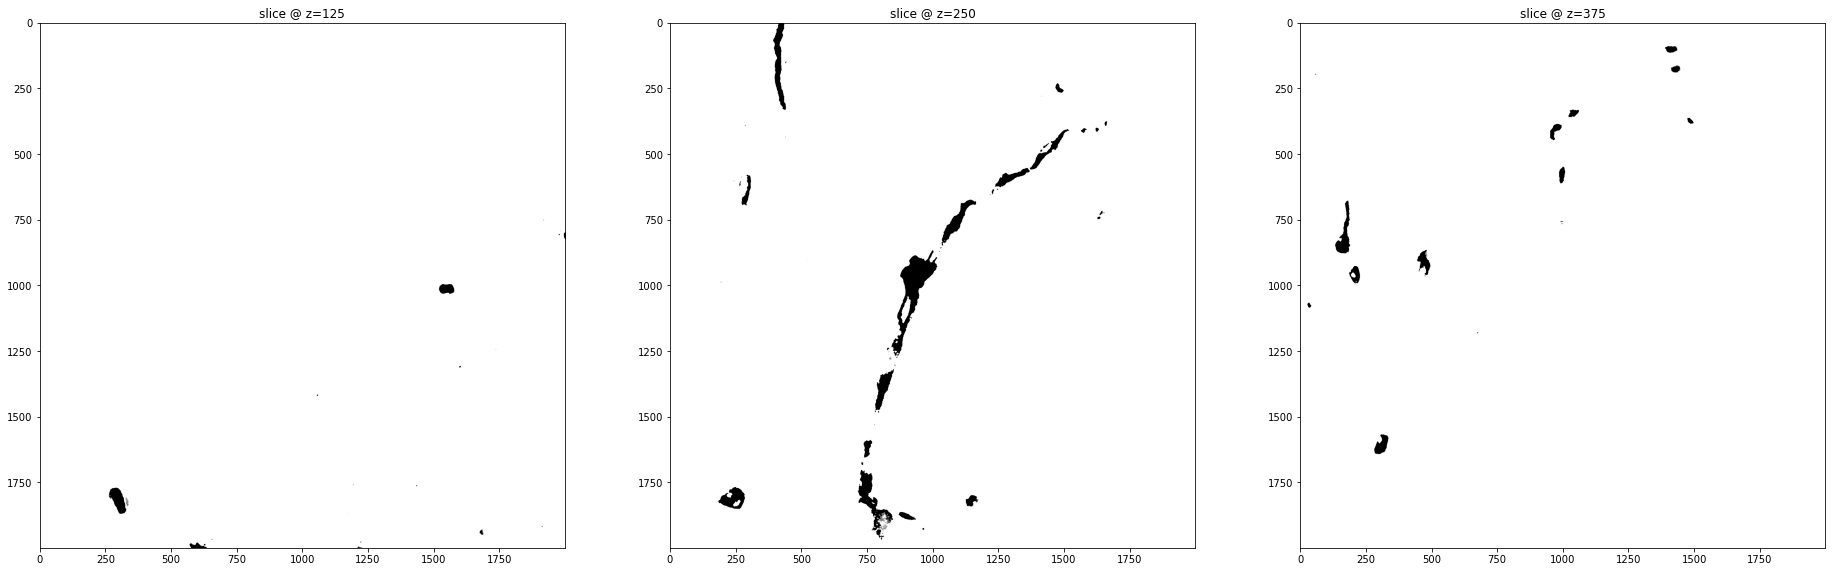

In [35]:
utilities.showZSlices(mask, mode='h5', n_slices=3, plot_size=10, vmin=0, vmax=1)

In [37]:
ground_truth.close()
image_h5.close()

In [36]:
np.mean(mask[250,:,:])

0.0170885